In [ ]:
import pandas as pd
import time
import numpy as np
from sklearn.cross_validation import train_test_split
import lightgbm as lgb

from sklearn import preprocessing
import matplotlib.pyplot as plt


def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    n_estimators = bst1.best_iteration
    lgb.plot_importance(bst1, max_num_features=300)
    plt.show()
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics+":", evals_results['valid'][metrics][n_estimators-1])

    return bst1

path = 'G:/Courses/EE380L Data Mining/project/'

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

print('load train...')
train_df = pd.read_csv(path+"train.csv", nrows=400000, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
print('load test...')
test_df = pd.read_csv(path+"test.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

import gc

len_train = len(train_df)
train_df=train_df.append(test_df)

del test_df
gc.collect()

print('data prep...')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')

gc.collect()

# # of clicks for each ip-day-hour combination
print('group by...')
gp = train_df[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
print('merge...')
train_df = train_df.merge(gp, on=['ip','day','hour'], how='left')
del gp
gc.collect()

# # of clicks for each ip-app combination
print('group by...')
gp = train_df[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
train_df = train_df.merge(gp, on=['ip','app'], how='left')
del gp
gc.collect()

# # of clicks for each ip-app-os combination
print('group by...')
gp = train_df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
train_df = train_df.merge(gp, on=['ip','app', 'os'], how='left')
del gp
gc.collect()


print("vars and data type: ")
train_df.info()
train_df['qty'] = train_df['qty'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

train_df.head(20)
test_df = train_df[len_train:]
val_df = train_df[(len_train-40000):len_train]
train_df = train_df[:(len_train-40000)]

print("train size: ", len(train_df))
print("valid size: ", len(val_df))
print("test size : ", len(test_df))

target = 'is_attributed'
predictors = ['app','device','os', 'channel', 'hour', 'day', 'qty', 'ip_app_count', 'ip_app_os_count']
categorical = ['app','device','os', 'channel', 'hour']


sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype('int')

gc.collect()

print("Training...")
params = {
    'learning_rate': 0.1,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':99 # because training data is extremely unbalanced 
}
bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=50, 
                        verbose_eval=True, 
                        num_boost_round=300, 
                        categorical_features=categorical)

del train_df
del val_df
gc.collect()

print("Predicting...")
sub['is_attributed'] = bst.predict(test_df[predictors])
#print("writing...")
#sub.to_csv('sub_lgb_balanced99.csv',index=False)
print("done...")
print(sub.info())


ax = lgb.plot_importance(bst, max_num_features=300)
plt.show()

In [ ]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
from contextlib import contextmanager

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
def df_add_counts(df, cols):
    arr_slice = df[cols].values
    unq, unqtags, counts = np.unique(np.ravel_multi_index(arr_slice.T, arr_slice.max(axis=0) + 1),
                                     return_inverse=True, return_counts=True)
    df["_".join(cols)+'_count'] = counts[unqtags]
    
def make_count_features(df):
    with timer("add count features"):
        df['click_time']= pd.to_datetime(df['click_time'])
        dt= df['click_time'].dt
        df['day'] = dt.day.astype('uint8')
        df['hour'] = dt.hour.astype('uint8')
        df['minute'] = dt.minute.astype('uint8')
        del(dt)
        
        df_add_counts(df, ['ip'])
        df_add_counts(df, ['ip','day','hour','minute'])
        df_add_counts(df, ['os','device'])
        df_add_counts(df, ['os','app','channel'])
        
        df_add_counts(df, ['ip', 'day', 'hour'])
        df_add_counts(df, ['ip', 'app'])
        df_add_counts(df, ['ip', 'app', 'os'])
        df_add_counts(df, ['ip', 'device'])
        df_add_counts(df, ['app', 'channel'])

def make_next_click_feature(df):
    with timer("Adding next click times"):
        D= 2**26
        df['category'] = (df['ip'].astype(str) + "_" + df['app'].astype(str) + "_" + df['device'].astype(str) \
                         + "_" + df['os'].astype(str)).apply(hash) % D
        click_buffer= np.full(D, 3000000000, dtype=np.uint32)
        df['epochtime']= df['click_time'].astype(np.int64) // 10 ** 9
        next_clicks= []
        for category, time in zip(reversed(df['category'].values), reversed(df['epochtime'].values)):
            next_clicks.append(click_buffer[category]-time)
            click_buffer[category]= time
        del(click_buffer)
        df['next_click']= list(reversed(next_clicks))
        
path = 'G:/Courses/EE380L Data Mining/project/'

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

with timer("load training data"):
    train_df = pd.read_csv(path+"train.csv", skiprows=range(1,131886954), nrows=20000, 
                           dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
    
with timer("load test data"):
    test_df = pd.read_csv(path+"test.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    
    
num_train = train_df.shape[0]
y = train_df.is_attributed.values

sub = pd.DataFrame()
sub['click_id'] = test_df.click_id.values

common_column = ['ip','app','device','os','channel','click_time']
concat_df = pd.concat([train_df[common_column],test_df[common_column]])

del train_df, test_df
gc.collect()

make_count_features(concat_df)
make_next_click_feature(concat_df)

gc.collect()

target = "is_attributed"
categorical_features = ['ip','app','os','channel','device']
predictors = list(set(concat_df.columns)-set([target])-set(['click_time','category','epochtime']))

lgbtrain = lgb.Dataset(concat_df.iloc[:num_train][predictors].values, label=y,
                      feature_name=predictors,
                      categorical_feature=categorical_features
                      )
                      
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': 4,
    'verbose': 0,
    'metric':'auc',     
 
    'learning_rate': 0.15,
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':99
}

evals_results = {}
num_boost_round = 50   # was 250
early_stopping_rounds = 30

booster = lgb.train(
     lgb_params, 
     lgbtrain, 
     valid_sets=[lgbtrain], 
     valid_names=['train'], 
     evals_result=evals_results, 
     num_boost_round=num_boost_round,
     early_stopping_rounds=early_stopping_rounds,
     verbose_eval=1
)

preditions=booster.predict(concat_df.iloc[num_train:][predictors].values)

sub['is_attributed']  = preditions

#sub.to_csv('my_lgb_sub_0.9772.csv', float_format='%.8f', index=False)

ax = lgb.plot_importance(booster, max_num_features=300)
plt.show()


In [20]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load subset of the training data
X_train = pd.read_csv('G:/Courses/EE380L Data Mining/project/train.csv', skiprows=range(1,131886954), nrows=300000, parse_dates=['click_time'])
X_test = pd.read_csv('G:/Courses/EE380L Data Mining/project/test.csv', nrows=10000, parse_dates=['click_time'])

# Show the head of the table
X_train.head()
X_test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [21]:
X_train['day'] = X_train['click_time'].dt.day.astype('uint8')
X_train['hour'] = X_train['click_time'].dt.hour.astype('uint8')
X_train['minute'] = X_train['click_time'].dt.minute.astype('uint8')
X_train['second'] = X_train['click_time'].dt.second.astype('uint8')
X_train.head()

X_test['day'] = X_test['click_time'].dt.day.astype('uint8')
X_test['hour'] = X_test['click_time'].dt.hour.astype('uint8')
X_test['minute'] = X_test['click_time'].dt.minute.astype('uint8')
X_test['second'] = X_test['click_time'].dt.second.astype('uint8')
X_test.head()

,click_id,ip,app,device,os,channel,click_time,day,hour,minute,second
0,0,5744,9,1,3,107,2017-11-10 04:00:00,10,4,0,0
1,1,119901,9,1,3,466,2017-11-10 04:00:00,10,4,0,0
2,2,72287,21,1,19,128,2017-11-10 04:00:00,10,4,0,0
3,3,78477,15,1,13,111,2017-11-10 04:00:00,10,4,0,0
4,4,123080,12,1,13,328,2017-11-10 04:00:00,10,4,0,0


In [53]:
'''
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ###############
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    
    # V2 Features #
    ###############
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    
    # V3 Features #
    ###############
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device']
]


# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = X_train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    X_train = X_train.merge(
        group_object['is_attributed']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'is_attributed': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )
    
X_train.head()
'''

'\nATTRIBUTION_CATEGORIES = [        \n    # V1 Features #\n    ###############\n    [\'ip\'], [\'app\'], [\'device\'], [\'os\'], [\'channel\'],\n    \n    # V2 Features #\n    ###############\n    [\'app\', \'channel\'],\n    [\'app\', \'os\'],\n    [\'app\', \'device\'],\n    \n    # V3 Features #\n    ###############\n    [\'channel\', \'os\'],\n    [\'channel\', \'device\'],\n    [\'os\', \'device\']\n]\n\n\n# Find frequency of is_attributed for each unique value in column\nfreqs = {}\nfor cols in ATTRIBUTION_CATEGORIES:\n    \n    # New feature name\n    new_feature = \'_\'.join(cols)+\'_confRate\'    \n    \n    # Perform the groupby\n    group_object = X_train.groupby(cols)\n    \n    # Group sizes    \n    group_sizes = group_object.size()\n    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence \n    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(\n        c

In [22]:
# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # V2 - GroupBy Features #
    #########################
    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['app'], 
     'select': 'ip', 
     'agg': lambda x: float(len(x)) / len(x.unique()), 
     'agg_name': 'AvgViewPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    #{'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    #{'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    #{'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    #{'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    #{'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    #{'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    #{'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    #{'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    #{'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'}, 
    #{'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'}    
]

# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = X_train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
    gp2 = X_test[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        X_train[new_feature] = gp[0].values
    else:
        X_train = X_train.merge(gp, on=spec['groupby'], how='left')
        
    if 'cumcount' == spec['agg']:
        X_test[new_feature] = gp2[0].values
    else:
        X_test = X_test.merge(gp2, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    del gp2
    gc.collect()

X_train.head()
X_test.head()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'channel'], and aggregating hour with var
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['app'], and aggregating ip with AvgViewPerDistinct
Grouping by ['app'], and aggregating channel with count
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique


,click_id,ip,app,device,os,channel,click_time,day,hour,minute,...,ip_day_channel_var_hour,ip_day_hour_count_channel,ip_app_count_channel,ip_app_os_count_channel,ip_app_day_hour_count_channel,ip_app_channel_mean_hour,app_AvgViewPerDistinct_ip,app_count_channel,ip_nunique_channel,ip_nunique_app
0,0,5744,9,1,3,107,2017-11-10 04:00:00,10,4,0,...,NaN,2,1,1,1,4,1.196780,1338,2,2
1,1,119901,9,1,3,466,2017-11-10 04:00:00,10,4,0,...,NaN,9,1,1,1,4,1.196780,1338,6,5
2,2,72287,21,1,19,128,2017-11-10 04:00:00,10,4,0,...,NaN,2,1,1,1,4,1.050420,500,2,2
3,3,78477,15,1,13,111,2017-11-10 04:00:00,10,4,0,...,NaN,4,1,1,1,4,1.035778,579,4,4
4,4,123080,12,1,13,328,2017-11-10 04:00:00,10,4,0,...,NaN,2,1,1,1,4,1.148333,1378,2,2


In [23]:
GROUP_BY_NEXT_CLICKS = [
    
    # V1
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},
    
    # V3
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    X_train[new_feature] = X_train[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    X_test[new_feature] = X_test[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    
X_train.head()
X_test.head()

>> Grouping by ['ip'], and saving time to next click in: ip_nextClick
>> Grouping by ['ip', 'app'], and saving time to next click in: ip_app_nextClick
>> Grouping by ['ip', 'channel'], and saving time to next click in: ip_channel_nextClick
>> Grouping by ['ip', 'os'], and saving time to next click in: ip_os_nextClick
>> Grouping by ['ip', 'app', 'device', 'os', 'channel'], and saving time to next click in: ip_app_device_os_channel_nextClick
>> Grouping by ['ip', 'os', 'device'], and saving time to next click in: ip_os_device_nextClick
>> Grouping by ['ip', 'os', 'device', 'app'], and saving time to next click in: ip_os_device_app_nextClick


,click_id,ip,app,device,os,channel,click_time,day,hour,minute,...,app_count_channel,ip_nunique_channel,ip_nunique_app,ip_nextClick,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick
0,0,5744,9,1,3,107,2017-11-10 04:00:00,10,4,0,...,1338,2,2,6.0,NaN,NaN,6.0,NaN,6.0,NaN
1,1,119901,9,1,3,466,2017-11-10 04:00:00,10,4,0,...,1338,6,5,1.0,NaN,NaN,10.0,NaN,10.0,NaN
2,2,72287,21,1,19,128,2017-11-10 04:00:00,10,4,0,...,500,2,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,78477,15,1,13,111,2017-11-10 04:00:00,10,4,0,...,579,4,4,5.0,NaN,NaN,5.0,NaN,5.0,NaN
4,4,123080,12,1,13,328,2017-11-10 04:00:00,10,4,0,...,1378,2,2,4.0,NaN,NaN,4.0,NaN,4.0,NaN


In [24]:
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

# Go through different group-by combinations
for fname, fset in HISTORY_CLICKS.items():
    
    # Clicks in the past
    X_train['prev_'+fname] = X_train. \
        groupby(fset). \
        cumcount(). \
        rename('prev_'+fname)
    X_test['prev_'+fname] = X_test. \
        groupby(fset). \
        cumcount(). \
        rename('prev_'+fname)
        
    # Clicks in the future
    X_train['future_'+fname] = X_train.iloc[::-1]. \
        groupby(fset). \
        cumcount(). \
        rename('future_'+fname).iloc[::-1]
    X_test['future_'+fname] = X_test.iloc[::-1]. \
        groupby(fset). \
        cumcount(). \
        rename('future_'+fname).iloc[::-1]

# Count cumulative subsequent clicks
X_train.head()
X_test.head()

,click_id,ip,app,device,os,channel,click_time,day,hour,minute,...,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks
0,0,5744,9,1,3,107,2017-11-10 04:00:00,10,4,0,...,NaN,NaN,6.0,NaN,6.0,NaN,0,0,0,0
1,1,119901,9,1,3,466,2017-11-10 04:00:00,10,4,0,...,NaN,NaN,10.0,NaN,10.0,NaN,0,0,0,0
2,2,72287,21,1,19,128,2017-11-10 04:00:00,10,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,3,78477,15,1,13,111,2017-11-10 04:00:00,10,4,0,...,NaN,NaN,5.0,NaN,5.0,NaN,0,0,0,0
4,4,123080,12,1,13,328,2017-11-10 04:00:00,10,4,0,...,NaN,NaN,4.0,NaN,4.0,NaN,0,0,0,0


[1]	train's auc: 0.89666
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.909533
[3]	train's auc: 0.911784
[4]	train's auc: 0.919435
[5]	train's auc: 0.918921
[6]	train's auc: 0.927406
[7]	train's auc: 0.92427
[8]	train's auc: 0.9245
[9]	train's auc: 0.924534
[10]	train's auc: 0.930933
[11]	train's auc: 0.941759
[12]	train's auc: 0.941797
[13]	train's auc: 0.94075
[14]	train's auc: 0.946186
[15]	train's auc: 0.948183
[16]	train's auc: 0.949833
[17]	train's auc: 0.951064
[18]	train's auc: 0.951081
[19]	train's auc: 0.954737
[20]	train's auc: 0.957509
[21]	train's auc: 0.958561
[22]	train's auc: 0.96014
[23]	train's auc: 0.959848
[24]	train's auc: 0.960197
[25]	train's auc: 0.96074
[26]	train's auc: 0.961285
[27]	train's auc: 0.961774
[28]	train's auc: 0.96323
[29]	train's auc: 0.963527
[30]	train's auc: 0.963566
[31]	train's auc: 0.964133
[32]	train's auc: 0.964782
[33]	train's auc: 0.966296
[34]	train's auc: 0.967043
[35]	train's auc: 0.967258
[36]	train

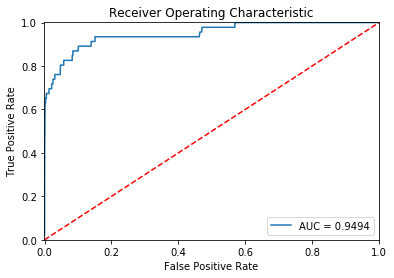

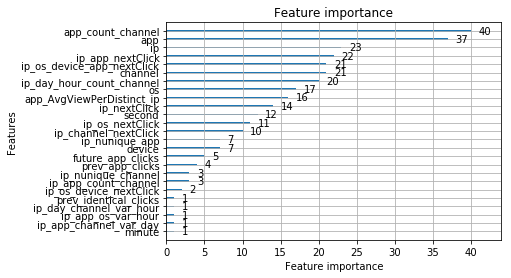

In [26]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
from contextlib import contextmanager
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt


def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
    
Y = X_train['is_attributed'][0:270000]
X = X_train.drop('is_attributed', axis=1).select_dtypes(include=[np.number])[0:270000]
x = X_train.drop('is_attributed', axis=1).select_dtypes(include=[np.number])[270000:]
y = X_train['is_attributed'][270000:]



lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': 4,
    'verbose': 0,
    'metric':'auc',     
 
    'learning_rate': 0.15,
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':99
}
evals_results = {}
num_boost_round = 50   # was 250
early_stopping_rounds = 30


lgbtrain = lgb.Dataset(X, label=Y)
booster = lgb.train(
     lgb_params, 
     lgbtrain, 
     valid_sets=[lgbtrain], 
     valid_names=['train'], 
     evals_result=evals_results, 
     num_boost_round=num_boost_round,
     early_stopping_rounds=early_stopping_rounds,
     verbose_eval=1
)

preditions=booster.predict(x)
print(preditions.shape)

fpr,tpr,thresholds = roc_curve(y,preditions)
roc_auc = auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

#with timer("load test data"):
#    test_df = pd.read_csv(path+"test.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
#sub = pd.DataFrame()
#sub['click_id'] = test_df['click_id'].astype('int')
#sub['is_attributed']  = preditions

#sub.to_csv('my_lgb_sub_0.9772.csv', float_format='%.8f', index=False)

ax = lgb.plot_importance(booster, max_num_features=300)
plt.show()

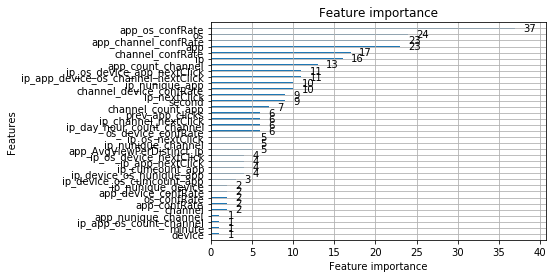

In [35]:
ax = lgb.plot_importance(booster, max_num_features=300)
plt.show()

In [51]:
test_df.shape
X_test.shape

(18790469, 7)